In [29]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.1 MB/s  0:00:00


In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.frequent_patterns
from mlxtend.frequent_patterns import fpgrowth

In [4]:
# Load your dataset
df = pd.read_csv(r'D:\5th sem\Pattern Recognition\Coursera - ML\Customer-Segmentation-and-Market-Basket-Analysis\online+retail\Online Retail.csv')

Feature scaling is crucial for clustering because clustering algorithms, particularly K-means, rely on distance calculations between data points to form clusters, and features with different scales can severely distort these calculations

K-means clustering uses Euclidean distance to measure similarity between data points. When features have different scales, those with larger numerical ranges will dominate the distance calculations. For example:

- Feature 1: Age (range 20-80)

- Feature 2: Income (range 30,000-100,000)

- Feature 3: Hours studied per week (range 5-40)

Without scaling, income values will have disproportionate influence on cluster formation simply because they're numerically larger, not because they're more important

Feature scaling is essential when:

- Features have different units (e.g., age in years, salary in dollars, scores as percentages)

- Features have vastly different ranges

- Using distance-based algorithms like K-means, hierarchical clustering, or DBSCAN

However, when all features have the same unit and similar ranges, scaling provides only marginal improvements.

In [18]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [19]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative quantities
df = df[df['Quantity'] > 0]

# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

RFM Feature Engineering, I am transforming the raw transaction records into three key behavioral metrics that describe each customer’s purchasing patterns.

RFM = Recency, Frequency, Monetary
- It’s a classic marketing analytics technique for understanding customer value and behavior.
- It’s perfect for unsupervised learning because it turns a huge, messy transactional dataset into a small, meaningful feature set for clustering.

In [20]:
#Recency (R) - Measures how recently a customer made a purchase.
#Frequency (F) - Measures how often a customer makes purchases.
#Monetary (M) - Measures how much money a customer has spent.


# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Then calculate reference date
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalPrice': 'Monetary'})

rfm.head()



,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Feature scaling is essential when:

- Features have different units (e.g., age in years, salary in dollars, scores as percentages)

- Features have vastly different ranges

- Using distance-based algorithms like K-means, hierarchical clustering, or DBSCAN

However, when all features have the same unit and similar ranges, scaling provides only marginal improvements.

K-means clustering uses Euclidean distance to measure similarity between data points. When features have different scales, those with larger numerical ranges will dominate the distance calculations. For example:

- Feature 1: Age (range 20-80)

- Feature 2: Income (range 30,000-100,000)

- Feature 3: Hours studied per week (range 5-40)

Without scaling, income values will have disproportionate influence on cluster formation simply because they're numerically larger, not because they're more important

In [22]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [23]:
# Find optimal k using Elbow Method
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)


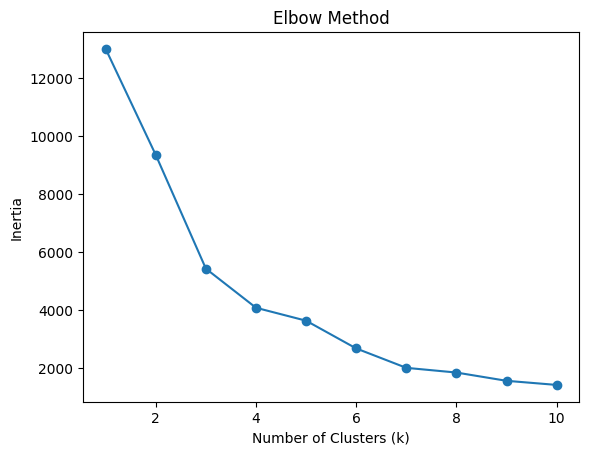

In [24]:
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

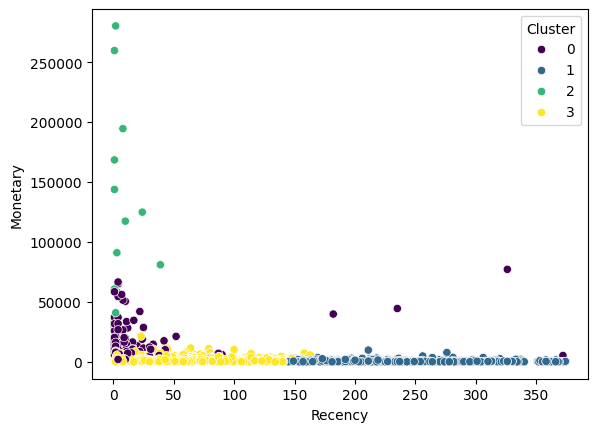

In [25]:
# Train K-Means with chosen k (say k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.show()

In [26]:
rfm.groupby('Cluster').mean()
#Identify which clusters are high-value, at-risk, or low-value customers.

,Recency,Frequency,Monetary
Cluster,,,
0,15.672986,22.047393,12453.225924
1,248.564030,1.551789,478.107581
2,7.384615,82.692308,127338.313846
3,43.910580,3.655748,1349.698298


Market Basket Analysis (Apriori)" is about finding associations between products that customers often buy together, using the Apriori algorithm.

Data Transformation
Before running Apriori, we usually:
- Convert transaction data into a basket format (one row per transaction, columns for products, 1 if purchased, 0 if not).

### Apriori Algorithm
The algorithm - Finds frequent itemsets: groups of items bought together above a certain minimum support threshold.
Generates association rules with:
- Support – frequency of occurrence in transactions.
- Confidence – probability of buying item B when item A is bought.
- Lift – how much more likely B is bought with A compared to random chance.

In [31]:
from mlxtend.frequent_patterns import apriori, association_rules

# Create basket: invoices as rows, products as columns
basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert to binary values
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by lift
rules.sort_values('lift', ascending=False).head()


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
73,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.029996,0.029186,0.021040,0.701439,24.033032,1.0,0.020165,3.251641,0.988027,0.551627,0.692463,0.711163
72,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.029186,0.029996,0.021040,0.720887,24.033032,1.0,0.020165,3.475313,0.987204,0.551627,0.712256,0.711163
75,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.037279,0.023522,0.021040,0.564399,23.994742,1.0,0.020163,2.241683,0.995433,0.529172,0.553907,0.729447
70,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
9,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037279,0.029996,0.024817,0.665702,22.193256,1.0,0.023698,2.901615,0.991919,0.584498,0.655364,0.746520
